# 5장 희소행렬과 혼동행렬
## (Contingency Tables Using Sparse Coordinate Matrices)

In [10]:
def variation_of_information(x, y):
    # 혼동행렬(contingency table)를 계산한다. 
    # 결합 확률 행렬(joint probability matrix)이라고도 한다.
    n = x.size
    Pxy = sparse.coo_matrix((np.full(n, 1/n), (x.ravel(), y.ravel())),
                            dtype=float).tocsr()

    # 1차원 배열로 변환하여, 주변 확률(marginal probabilities)을 계산한다.
    px = np.ravel(Pxy.sum(axis=1))
    py = np.ravel(Pxy.sum(axis=0))

    # 정보 변형을 계산하는 데 희소행렬 선형 대수를 사용한다.
    # 역 대각행렬(inverse diagonal matrices)을 계산한다.
    Px_inv = sparse.diags(invert_nonzero(px))
    Py_inv = sparse.diags(invert_nonzero(py))

    # 엔트로피(entropy)를 계산한다.
    hygx = px @ xlog1x(Px_inv @ Pxy).sum(axis=1)
    hxgy = xlog1x(Pxy @ Py_inv).sum(axis=0) @ py

    # 엔트로피의 합을 반환한다.
    return float(hygx + hxgy)

## 5.1 혼동행렬

In [11]:
import numpy as np

pred = np.array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1])
gt   = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [12]:
def confusion_matrix(pred, gt):
    cont = np.zeros((2, 2))
    for i in [0, 1]:
        for j in [0, 1]:
            cont[i, j] = np.sum((pred == i) & (gt == j))
    return cont

confusion_matrix(pred, gt)

array([[ 3.,  1.],
       [ 2.,  4.]])

### 5.1.1 연습문제 : 혼동행렬의 계산 복잡성
### 5.1.2 연습문제 : 혼동행렬을 계산하는 대체 알고리즘
### 5.1.3 연습문제 : 다중 혼동행렬 계산하기

## 5.2 scipy.sparse 데이터 형식
### 5.2.1 COO 형식

In [13]:
s = np.array([[ 4,  0, 3],
              [ 0, 32, 0]], dtype=float)

from scipy import sparse

data = np.array([4, 3, 32], dtype=float)
row = np.array([0, 0, 1])
col = np.array([0, 2, 1])

s_coo = sparse.coo_matrix((data, (row, col)))
s_coo.toarray()

array([[  4.,   0.,   3.],
       [  0.,  32.,   0.]])

In [14]:
s_coo.A

array([[  4.,   0.,   3.],
       [  0.,  32.,   0.]])

### 5.2.2 연습문제 : COO 형식 표현하기

In [16]:
s2 = np.array([[0, 0, 6, 0, 0],
               [1, 2, 0, 4, 5],
               [0, 1, 0, 0, 0],
               [9, 0, 0, 0, 0],
               [0, 0, 0, 6, 7]])

### 5.2.3 CSR 형식

In [19]:
row = [0, 1, 1, 1, 1, 2, 3, 4, 4]
col = [2, 0, 1, 3, 4, 1, 0, 3, 4]

indptr = [0, 1, 5, 6, 7, 9]
data = np.array([6, 1, 2, 4, 5, 1, 9, 6, 7])

coo = sparse.coo_matrix((data, (row, col)))
csr = sparse.csr_matrix((data, col, indptr))

print('COO와 CSR의 배열은 같다 : ',
      np.all(coo.A == csr.A))
print('CSR과 넘파이 배열은 같다 : ',
      np.all(s2 == csr.A))

COO와 CSR의 배열은 같다 :  True
CSR과 넘파이 배열은 같다 :  True


## 5.3 희소행렬 애플리케이션 : 이미지 변환

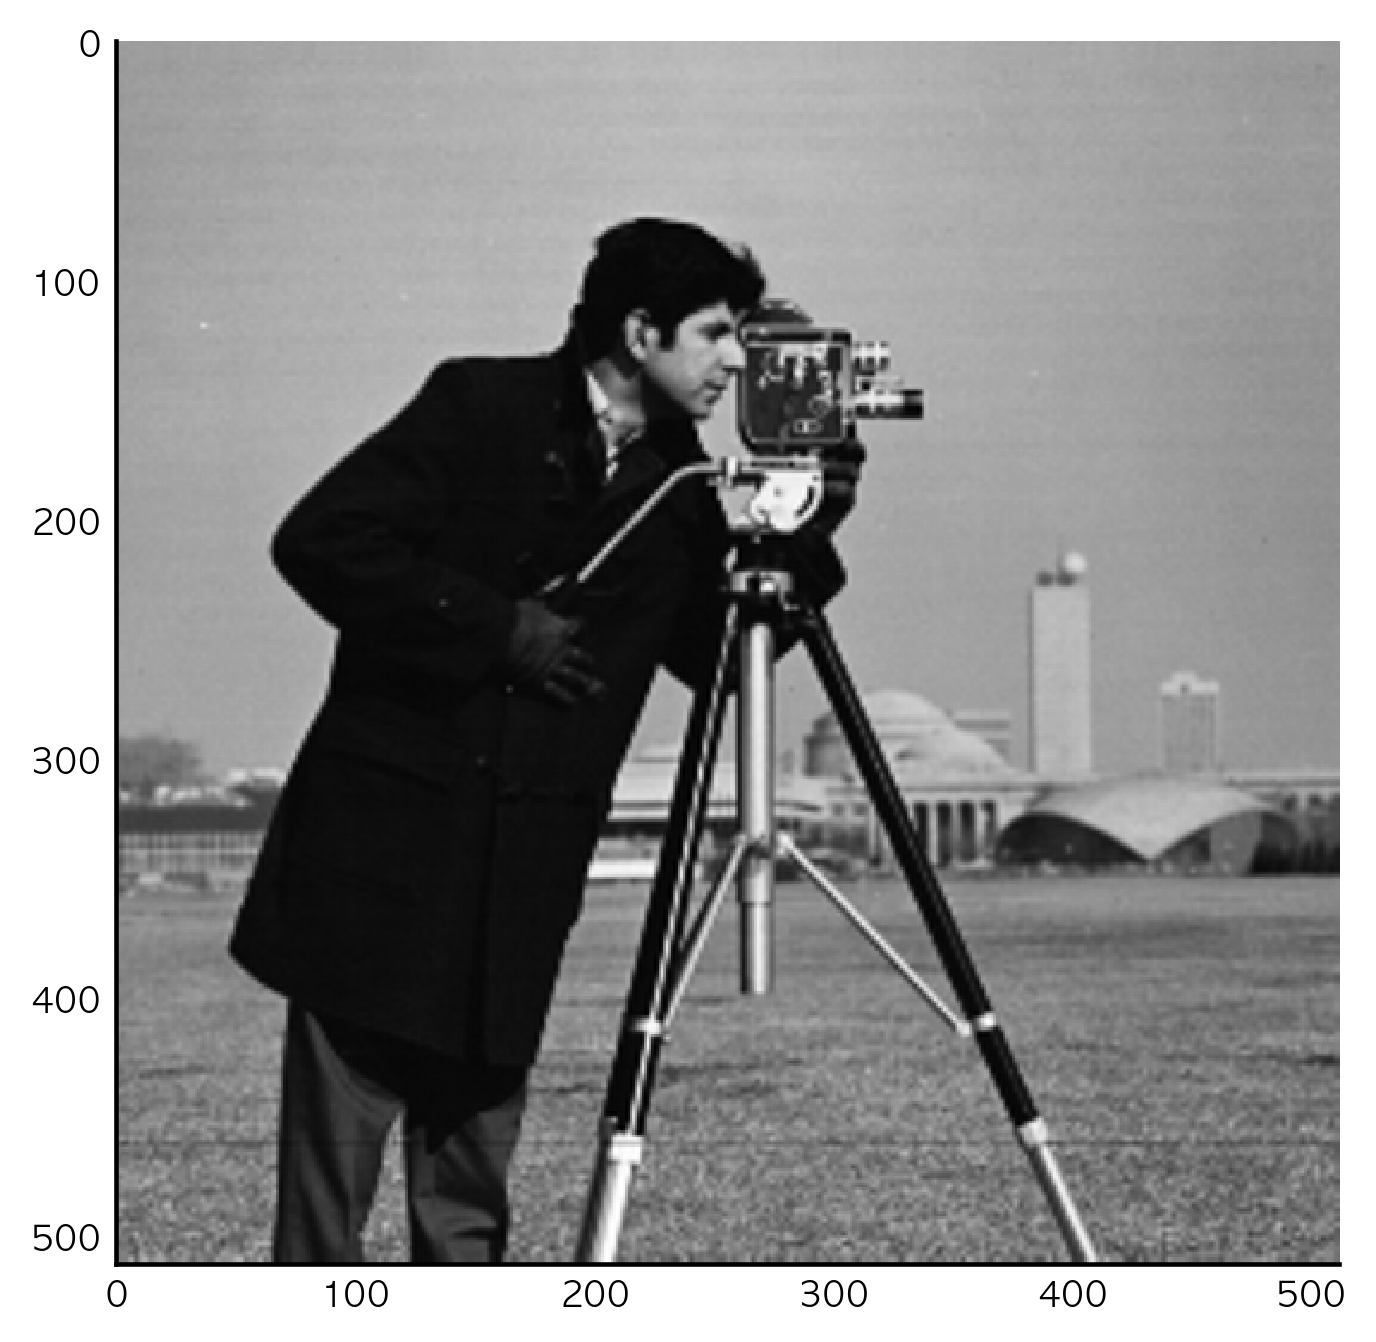

In [29]:
# 그래프를 바로 표시하고, 사용자 정의 스타일을 적용한다.
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('style/elegant.mplstyle')

from skimage import data

image = data.camera()
plt.imshow(image);

In [23]:
angle = 30
c = np.cos(np.deg2rad(angle))
s = np.sin(np.deg2rad(angle))
H = np.array([[c, -s,  0],
              [s,  c,  0],
              [0, 0, 1]])

point = np.array([1, 0, 1])
print(np.sqrt(3) / 2)
print(H @ point)

0.866025403784
[ 0.8660254  0.5        1.       ]


In [24]:
print(H @ H @ H @ point)

[  2.14607521e-16   1.00000000e+00   1.00000000e+00]


In [25]:
from itertools import product

def homography(tf, image_shape):
    """선형 연산자로 호모그래피 변환 및 보간법을 나타낸다.

    매개변수
    ----------
    tf : (3, 3) ndarray
         변환행렬
    image_shape : (M, N)
         입력 회색 이미지 모양

    반환값
    -------
    A : (M * N, M * N) 희소행렬
        변환 + 이중 선형 보간법을 나타내는 선형 연산자

    """
    # 역행렬 . 
    # 각 출력 픽셀의 해당 입력 픽셀을 찾아서 알려준다.
    H = np.linalg.inv(tf)

    m, n = image_shape

    # COO 행렬을 생성한다(또는 IJK 행렬이라고 부른다).
    # 행 좌표(I), 열 좌표(J), 값(K)
    row, col, values = [], [], []

    # 각 출력 이미지에 대한 픽셀을 처리한다.
    for sparse_op_row, (out_row, out_col) in \
            enumerate(product(range(m), range(n))):

        # 입력 이미지에서 나온 값을 계산한다.
        in_row, in_col, in_abs = H @ [out_row, out_col, 1]
        in_row /= in_abs
        in_col /= in_abs

        # 좌표가 원본 이미지 밖에 있는 경우, 이 좌표를 무시한다.
        # 이 좌표는 0이다.
        if (not 0 <= in_row < m - 1 or
                not 0 <= in_col < n - 1):
            continue

        # 4개의 주변 픽셀을 찾아서, 그 값을 보간하여
        # 출력 픽셀값을 정확하게 추정할 수 있다.
        # 왼쪽 위 구석부터 시작한다. 각 방향의 주변 픽셀은
        # 1 거리만큼 떨어져 있다.

        top = int(np.floor(in_row))
        left = int(np.floor(in_col))

        # 입력 이미지에서 선택된 픽셀 4개에
        # 매핑된 출력 픽셀의 위치를 계산한다.
        # https://commons.wikimedia.org/wiki/File:BilinearInterpolation.svg
        t = in_row - top
        u = in_col - left

        # 희소 연산자 행렬의 현재 행은 
        # 변수(sparse_op_row)를 포함한 조정된 출력 픽셀 좌표다.
        # 4개의 열에 해당하는 4개의 주변 입력 픽셀의 가중 평균을 취한다.
        # 따라서 행 인덱스를 4번 확장한다.
        row.extend([sparse_op_row] * 4)

        # 이중 선형 보간 알고리즘을 사용하여
        # 실제 가중치를 계산한다.
        # https://en.wikipedia.org/wiki/Bilinear_interpolation
        sparse_op_col = np.ravel_multi_index(
                ([top,  top,      top + 1, top + 1 ],
                 [left, left + 1, left,    left + 1]), dims=(m, n))
        col.extend(sparse_op_col)
        values.extend([(1-t) * (1-u), (1-t) * u, t * (1-u), t * u])

    operator = sparse.coo_matrix((values, (row, col)),
                                  shape=(m*n, m*n)).tocsr()
    return operator


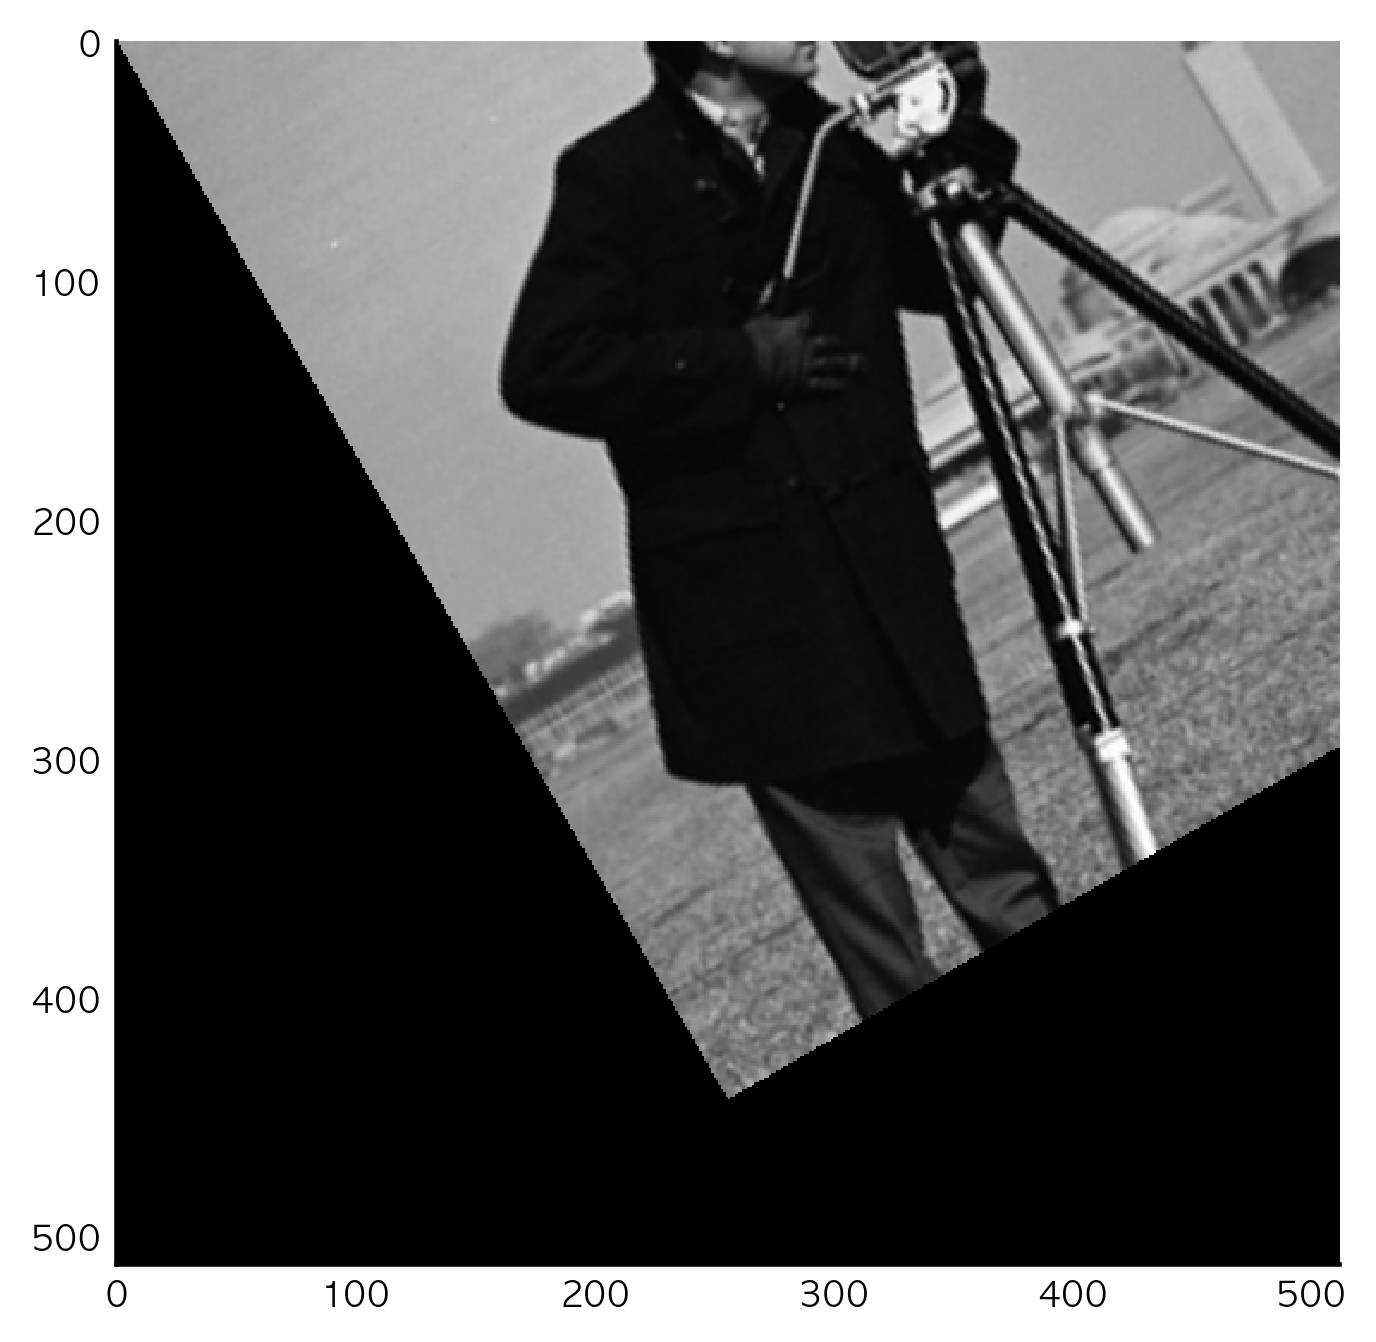

In [30]:
def apply_transform(image, tf):
    return (tf @ image.flat).reshape(image.shape)

tf = homography(H, image.shape)
out = apply_transform(image, tf)
plt.imshow(out);

### 5.3.1 연습문제 : 이미지 회전

## 5.4 (다시) 혼동행렬

In [33]:
row = [0, 0, 2]
col = [1, 1, 2]
dat = [5, 7, 1]
S = sparse.coo_matrix((dat, (row, col)))
print(S.toarray())

[[ 0 12  0]
 [ 0  0  0]
 [ 0  0  1]]


In [35]:
import numpy as np
from scipy import sparse

def confusion_matrix(pred, gt):
    cont = sparse.coo_matrix((np.ones(pred.size), (pred, gt)))
    return cont

pred = np.array([0, 1, 0, 0, 1, 1, 1, 0, 1, 1])
gt = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
cont = confusion_matrix(pred, gt)
print(cont)

  (0, 0)	1.0
  (1, 0)	1.0
  (0, 0)	1.0
  (0, 0)	1.0
  (1, 0)	1.0
  (1, 1)	1.0
  (1, 1)	1.0
  (0, 1)	1.0
  (1, 1)	1.0
  (1, 1)	1.0


In [36]:
print(cont.toarray())

[[ 3.  1.]
 [ 2.  4.]]


### 5.4.1 연습문제 : 메모리 사용량 줄이기

## 5.5 분할과 혼동행렬

In [39]:
seg = np.array([[1, 1, 2],
                [1, 2, 2],
                [3, 3, 3]], dtype=int)
gt = np.array([[1, 1, 1],
               [1, 1, 1],
               [2, 2, 2]], dtype=int)

print(seg.ravel())
print(gt.ravel())

[1 1 2 1 2 2 3 3 3]
[1 1 1 1 1 1 2 2 2]


In [40]:
cont = sparse.coo_matrix((np.ones(seg.size),
                         (seg.ravel(), gt.ravel())))
print(cont)

  (1, 1)	1.0
  (1, 1)	1.0
  (2, 1)	1.0
  (1, 1)	1.0
  (2, 1)	1.0
  (2, 1)	1.0
  (3, 2)	1.0
  (3, 2)	1.0
  (3, 2)	1.0


In [41]:
print(cont.toarray())

[[ 0.  0.  0.]
 [ 0.  3.  0.]
 [ 0.  3.  0.]
 [ 0.  0.  3.]]


## 5.6 정보 이론 요약
### 5.6.1 연습문제 : 조건부 엔트로피 계산하기

In [44]:
S = np.array([[0, 1],
              [2, 3]], int)
T = np.array([[0, 1],
              [0, 1]], int)
S.ravel()

array([0, 1, 2, 3])

In [45]:
cont = sparse.coo_matrix((np.broadcast_to(1., S.size),
                                         (S.ravel(), T.ravel())))
cont = cont.toarray()
cont

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.]])

In [49]:
cont /= np.sum(cont)

p_S = np.sum(cont, axis=1)
p_T = np.sum(cont, axis=0)

print('log (0) 결과 : ', np.log2(0))
print('0 x log (0) 결과 : ', 0 * np.log2(0))

log (0) 결과 :  -inf
0 x log (0) 결과 :  nan


/Users/achoi/miniconda3/envs/elegant-scipy/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log2
  
/Users/achoi/miniconda3/envs/elegant-scipy/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys
/Users/achoi/miniconda3/envs/elegant-scipy/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


In [50]:
def xlog1x(arr_or_mat):
    """배열 또는 행렬의 요소의 엔트로피 함수를 계산한다.

    매개변수
    ----------
    arr_or_mat : 넘파이 배열 또는 사이파이 희소행렬
         입력값은 확률 배열이다. 
         희소행렬의 경우 `data` 속성이 있는 경우에만 지원한다.

    반환값
    -------
    out : 배열 또는 희소행렬 (매개변수 유형과 같음)
        매개변수의 항목이 0인 경우, 0으로 유지한다.
        그 외 다른 모든 항목은 밑(base)이 2인 log와 음수로 곱한다.
    """

    out = arr_or_mat.copy()
    if isinstance(out, sparse.spmatrix):
        arr = out.data
    else:
        arr = out
    nz = np.nonzero(arr)
    arr[nz] *= -np.log2(arr[nz])

    return out

In [52]:
a = np.array([0.25, 0.25, 0, 0.25, 0.25])
xlog1x(a)

array([ 0.5,  0.5,  0. ,  0.5,  0.5])

In [53]:
mat = sparse.csr_matrix([[0.125, 0.125, 0.25,    0],
                         [0.125, 0.125,    0, 0.25]])
xlog1x(mat).A

array([[ 0.375,  0.375,  0.5  ,  0.   ],
       [ 0.375,  0.375,  0.   ,  0.5  ]])

## 5.8 희소행렬을 위한 넘파이 배열

In [54]:
import numpy as np
from scipy import sparse

def invert_nonzero(arr):
    arr_inv = arr.copy()
    nz = np.nonzero(arr)
    arr_inv[nz] = 1 / arr[nz]

    return arr_inv

def variation_of_information(x, y):
    # 혼동행렬을 계산한다. 
    # 결합 확률 행렬(joint probability matrix)이라고도 한다.
    n = x.size
    Pxy = sparse.coo_matrix((np.full(n, 1/n), (x.ravel(), y.ravel())),
                            dtype=float).tocsr()

    # 1차원 배열로 변환하여 주변 확률(marginal probability)을 계산한다.
    px = np.ravel(Pxy.sum(axis=1))
    py = np.ravel(Pxy.sum(axis=0))

    # 정보 변형(VI)을 계산하기 위해서, 희소행렬 선형 대수를 사용한다.
    # 먼저, 역 대각행렬을 계산한다.
    Px_inv = sparse.diags(invert_nonzero(px))
    Py_inv = sparse.diags(invert_nonzero(py))

    # 다음, 엔트로피를 계산한다.
    hygx = px @ xlog1x(Px_inv @ Pxy).sum(axis=1)
    hxgy = xlog1x(Pxy @ Py_inv).sum(axis=0) @ py

    # 엔트로피의 합을 반환한다.
    return float(hygx + hxgy)

In [55]:
variation_of_information(S, T)

1.0

## 5.9 정보 변형 사용하기

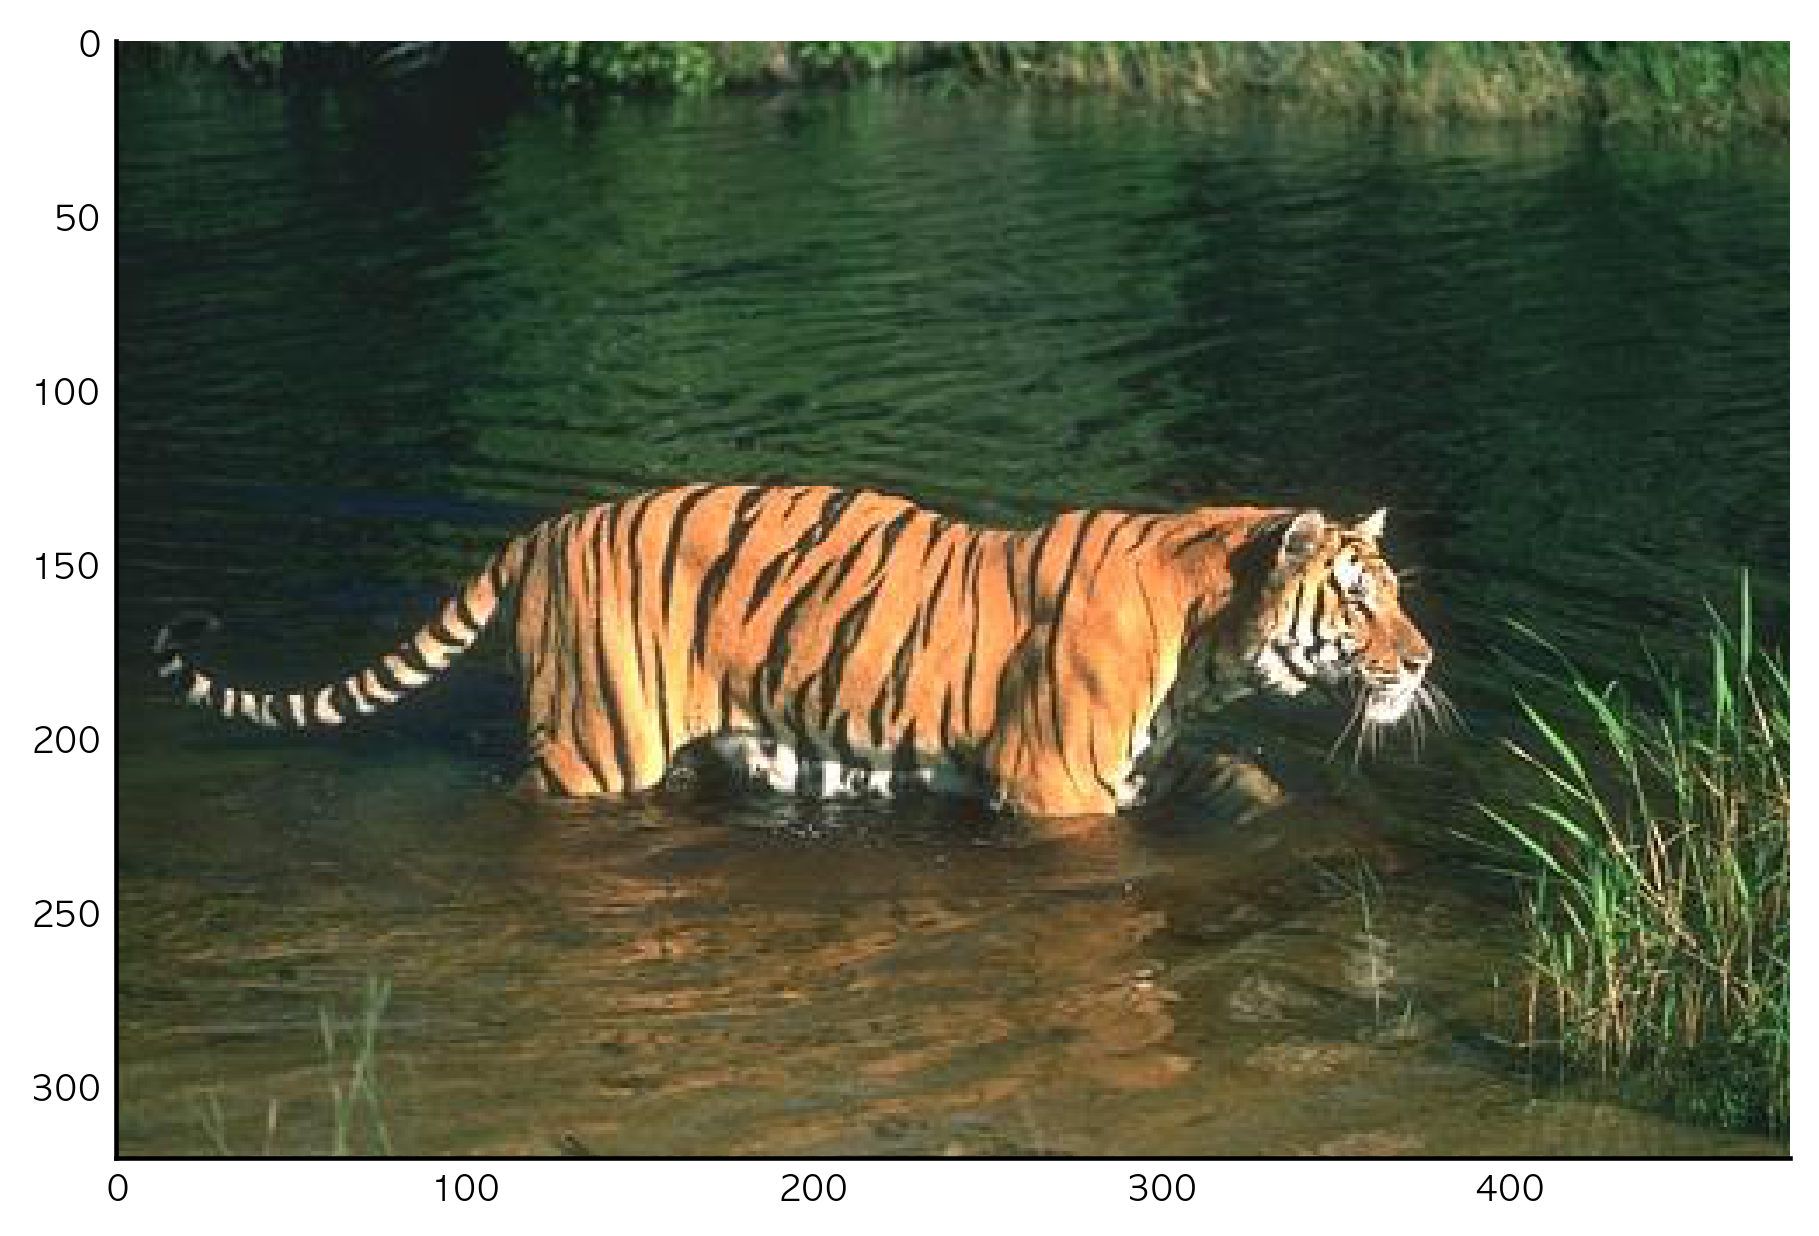

In [56]:
from skimage import io

url = ('http://www.eecs.berkeley.edu/Research/Projects/CS/vision/bsds'
       '/BSDS300/html/images/plain/normal/color/108073.jpg')
tiger = io.imread(url)

plt.imshow(tiger);

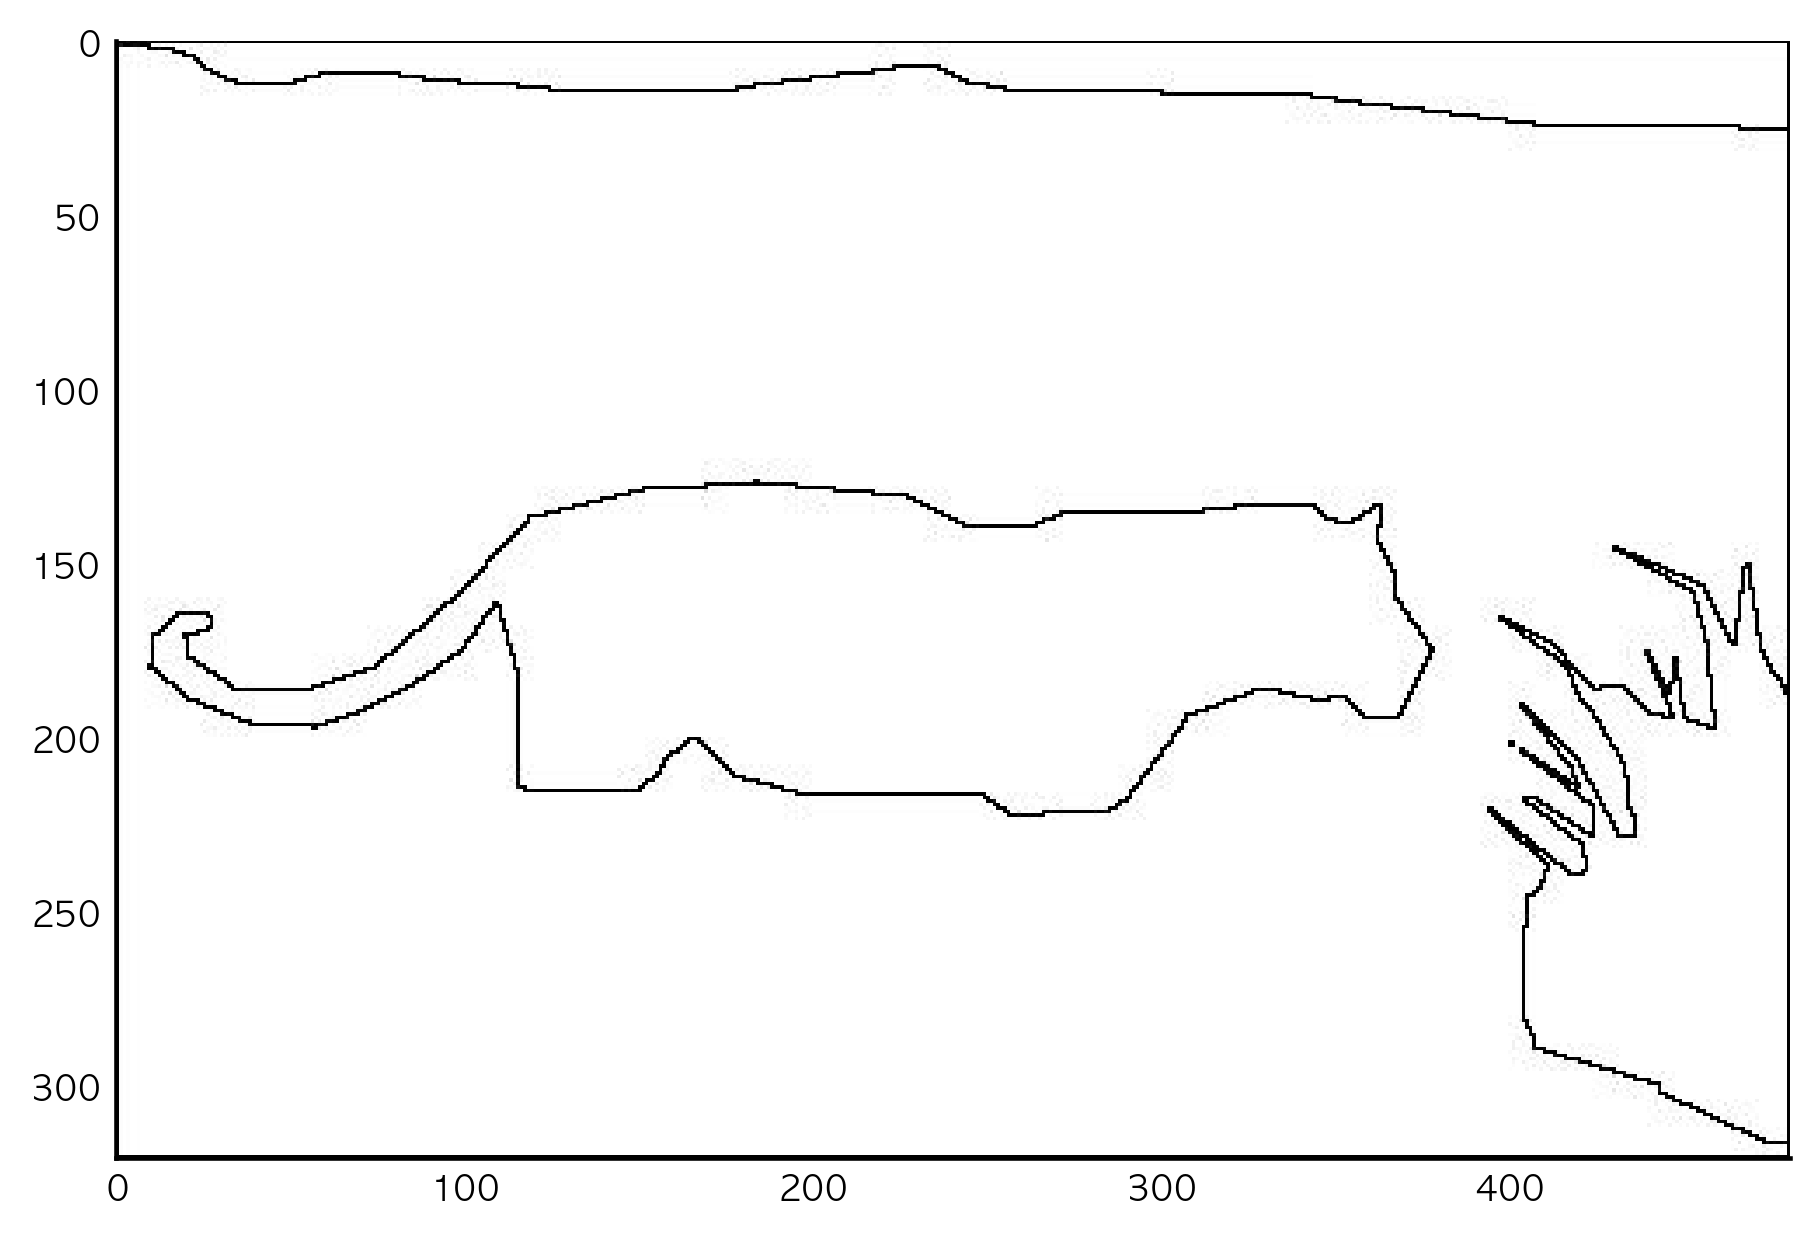

In [57]:
from scipy import ndimage as ndi
from skimage import color

human_seg_url = ('http://www.eecs.berkeley.edu/Research/Projects/CS/'
                 'vision/bsds/BSDS300/html/images/human/normal/'
                 'outline/color/1122/108073.jpg')
boundaries = io.imread(human_seg_url)
plt.imshow(boundaries);

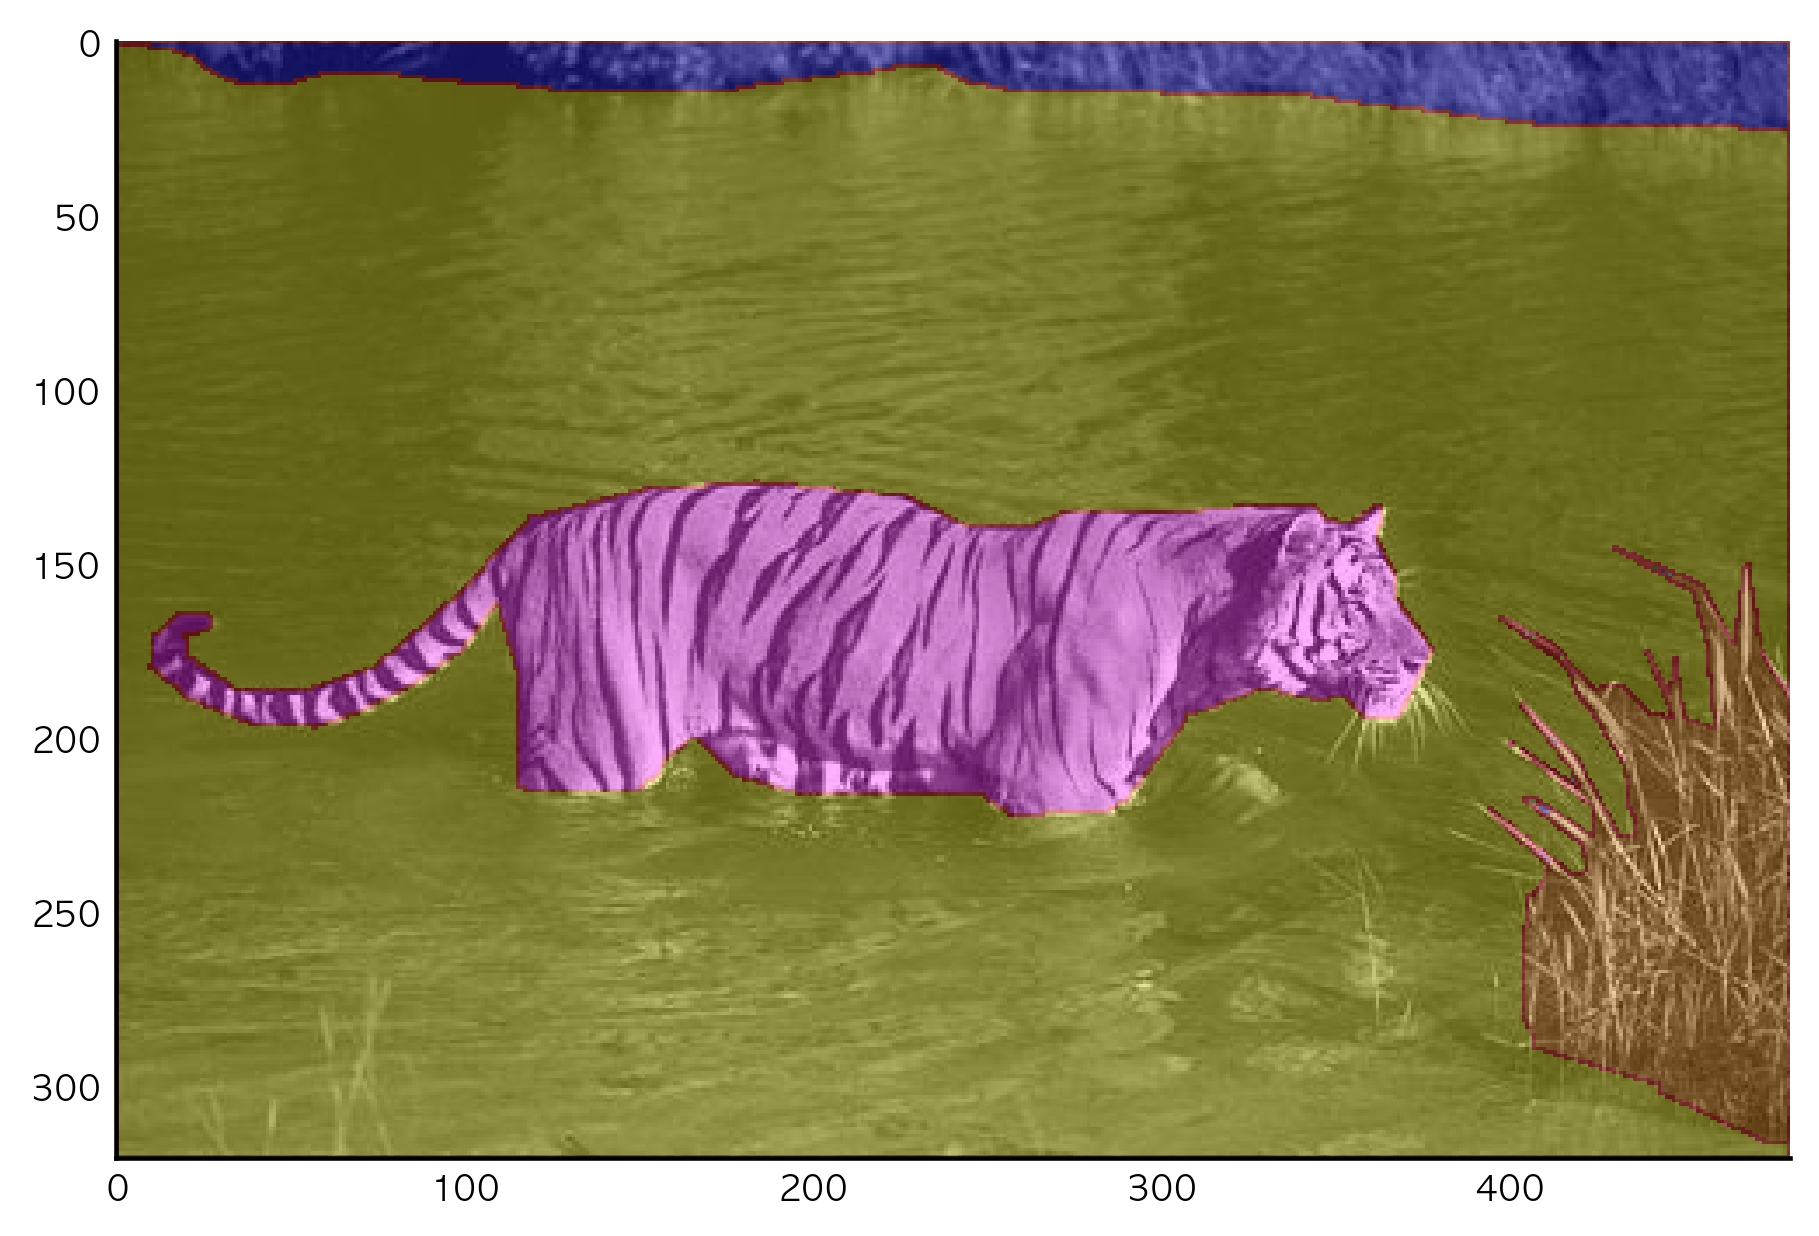

In [58]:
human_seg = ndi.label(boundaries > 100)[0]
plt.imshow(color.label2rgb(human_seg, tiger));

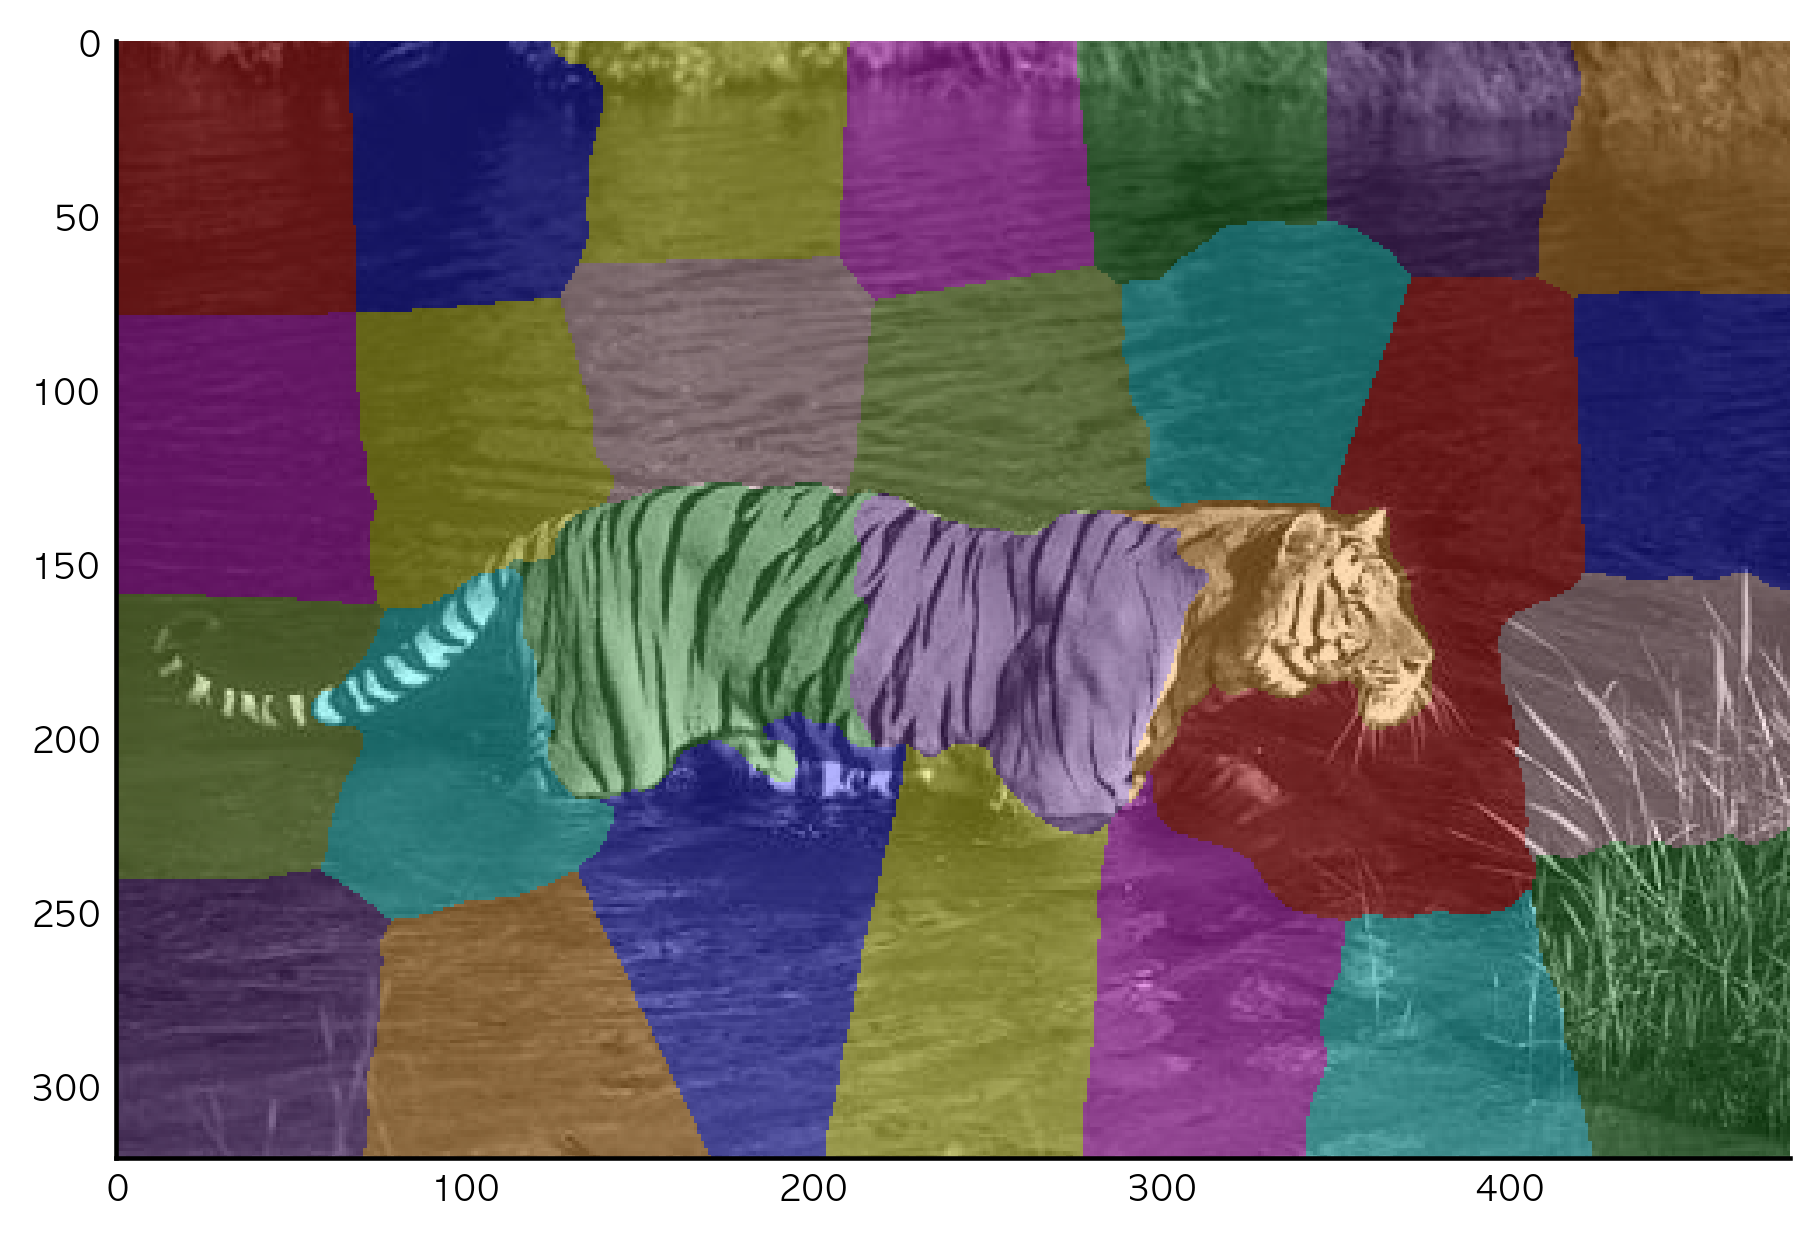

In [75]:
# 지역 근접 그래프(RGA) - 3장 참조
import networkx as nx
import numpy as np
from skimage.future import graph

def add_edge_filter(values, graph):
    current = values[0]
    neighbors = values[1:]
    for neighbor in neighbors:
        graph.add_edge(current, neighbor)
    return 0. # 반환값은 사용되지 않지만, generic_filter() 함수에서 필요하다.

def build_rag(labels, image):
    g = nx.Graph()
    footprint = ndi.generate_binary_structure(labels.ndim, connectivity=1)
    for j in range(labels.ndim):
        fp = np.swapaxes(footprint, j, 0)
        fp[0, ...] = 0  # 각 축 footprint 상단을 0으로 처리한다.
    _ = ndi.generic_filter(labels, add_edge_filter, footprint=footprint,
                          mode='nearest', extra_arguments=(g,))
    for n in g:
        g.node[n]['total color'] = np.zeros(3, np.double)
        g.node[n]['pixel count'] = 0
    for index in np.ndindex(labels.shape):
        n = labels[index]
        g.node[n]['total color'] += image[index]
        g.node[n]['pixel count'] += 1
    return g

def threshold_graph(g, t):
    to_remove = [(u, v) for (u, v, d) in g.edges(data=True)
                 if d['weight'] > t]
    g.remove_edges_from(to_remove)


# 베이스라인 분할(Baseline segmentation)
from skimage import segmentation
seg = segmentation.slic(tiger, n_segments=30, compactness=40.0,
                                   enforce_connectivity=True, sigma=3)
plt.imshow(color.label2rgb(seg, tiger));

In [76]:
def rag_segmentation(base_seg, image, threshold=80):
    g = build_rag(base_seg, image)
    for n in g:
        node = g.node[n]
        node['mean'] = node['total color'] / node['pixel count']
    for u, v in g.edges():
        d = g.node[u]['mean'] - g.node[v]['mean']
        g[u][v]['weight'] = np.linalg.norm(d)

    threshold_graph(g, threshold)

    map_array = np.zeros(np.max(seg) + 1, int)
    for i, segment in enumerate(nx.connected_components(g)):
        for initial in segment:
            map_array[int(initial)] = i
    segmented = map_array[seg]
    return(segmented)

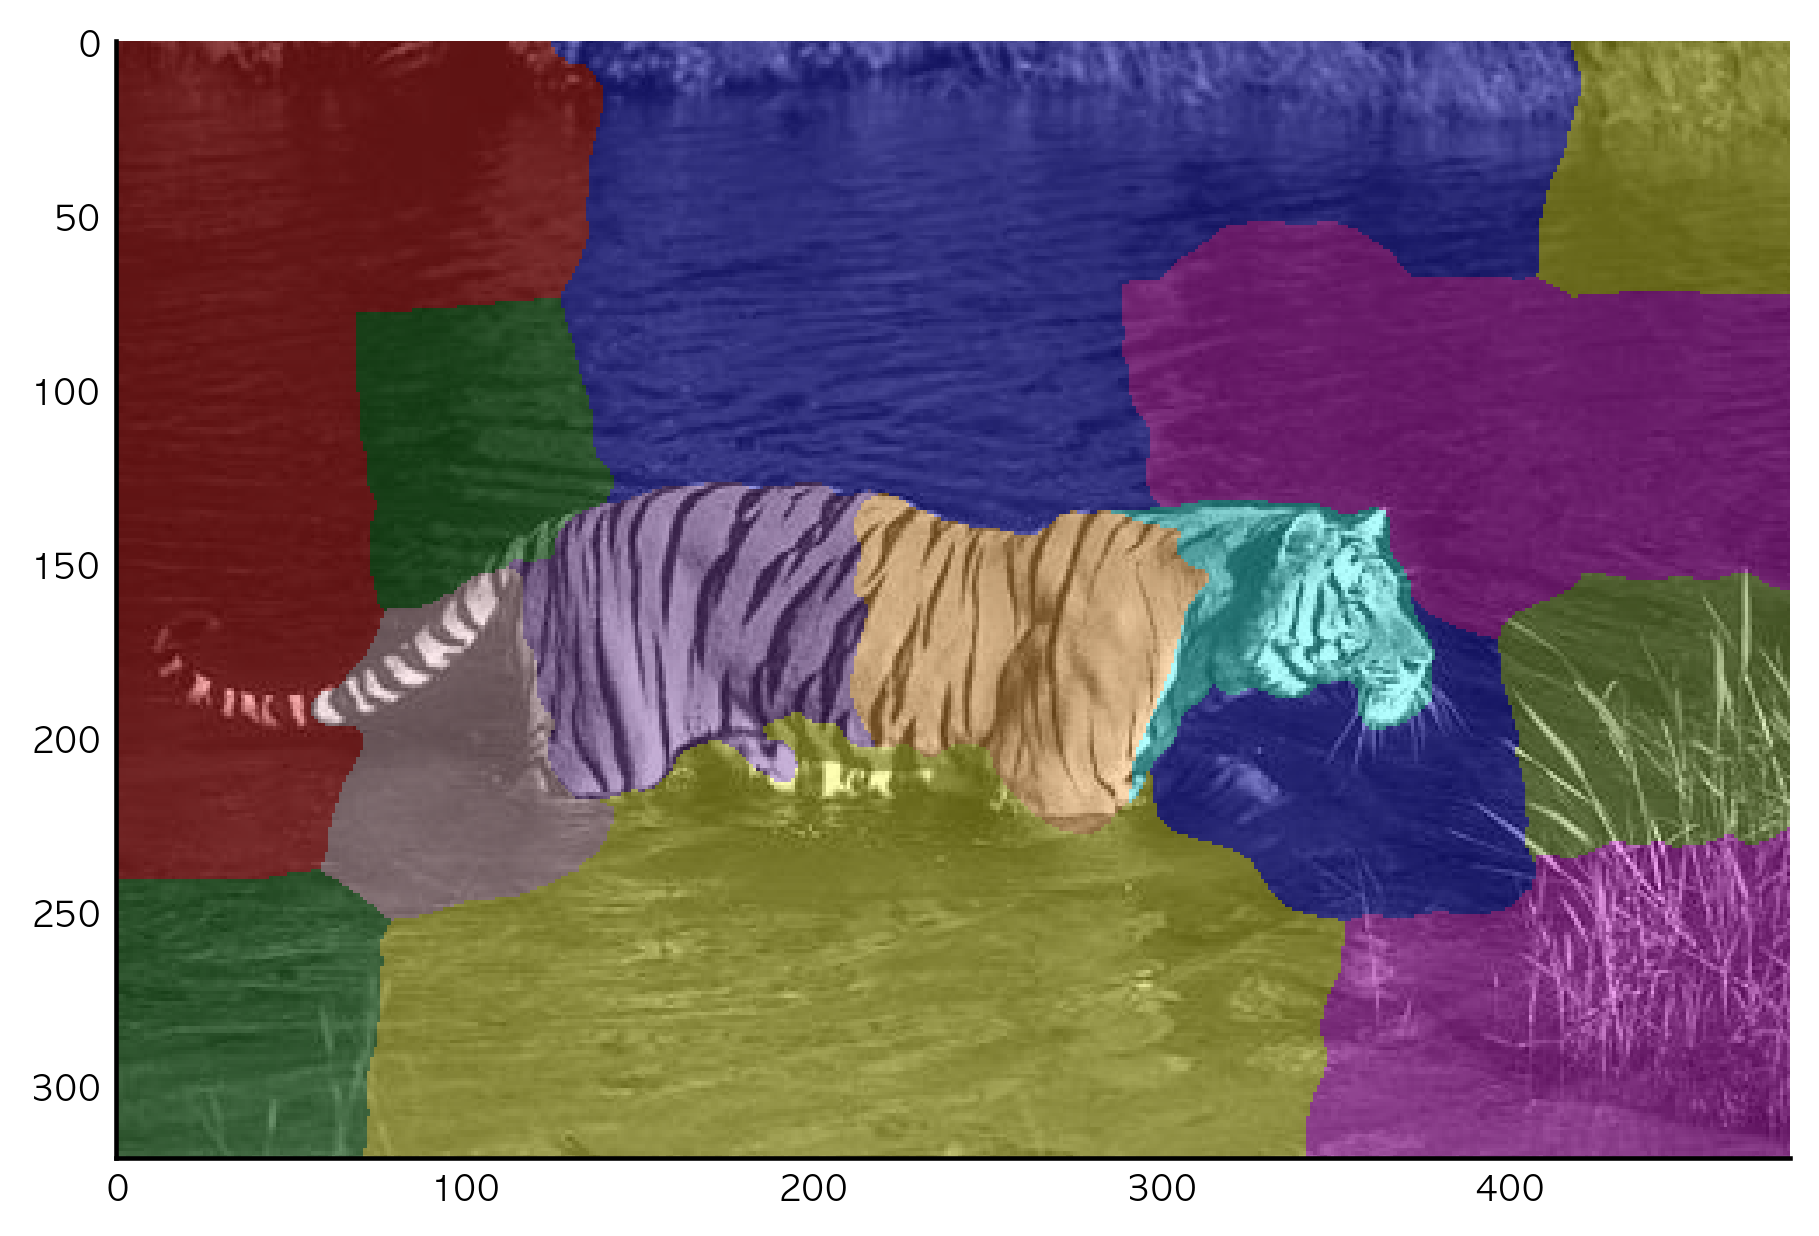

In [77]:
auto_seg_10 = rag_segmentation(seg, tiger, threshold=10)
plt.imshow(color.label2rgb(auto_seg_10, tiger));

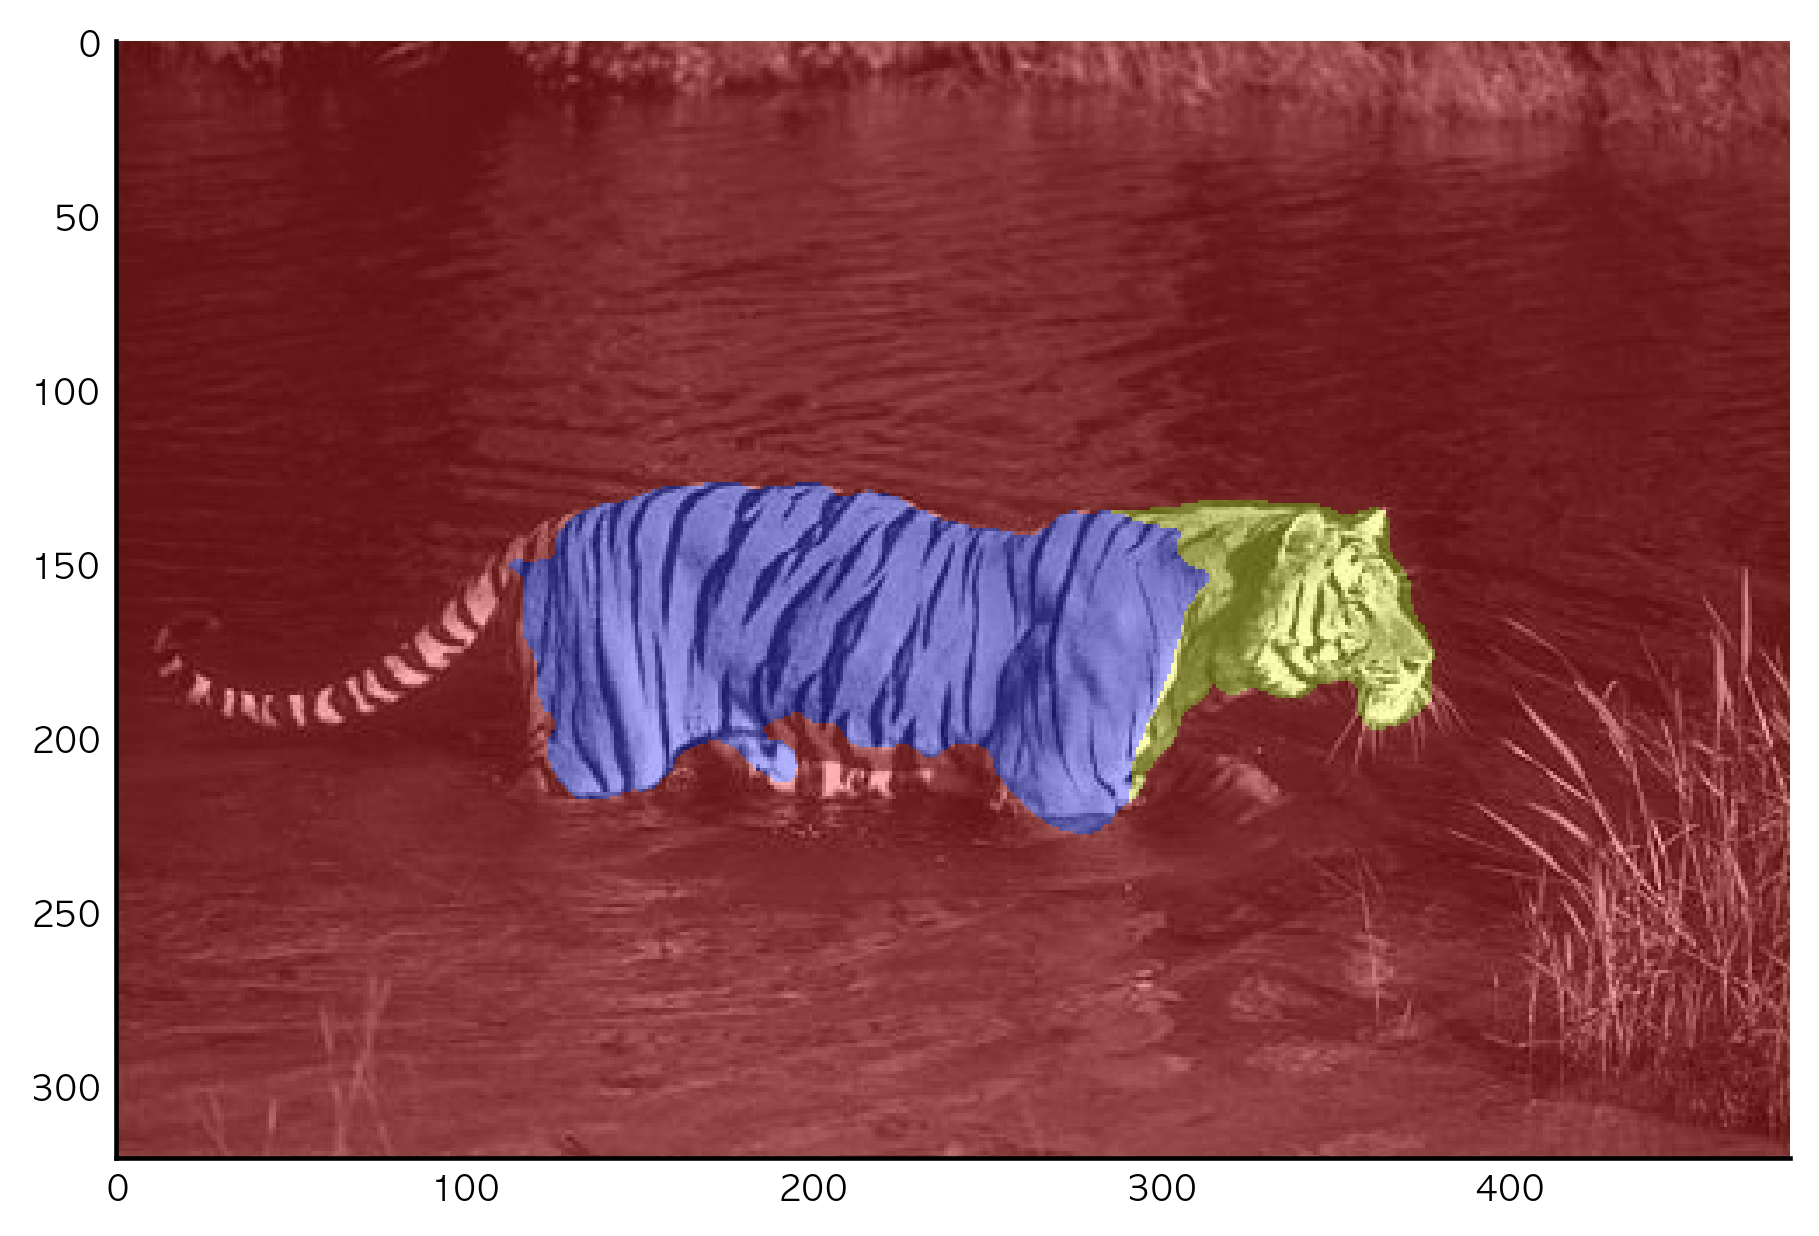

In [78]:
auto_seg_40 = rag_segmentation(seg, tiger, threshold=40)
plt.imshow(color.label2rgb(auto_seg_40, tiger));

In [79]:
variation_of_information(auto_seg_10, human_seg)

3.44884607874861

In [80]:
variation_of_information(auto_seg_40, human_seg)

1.0381218706889725

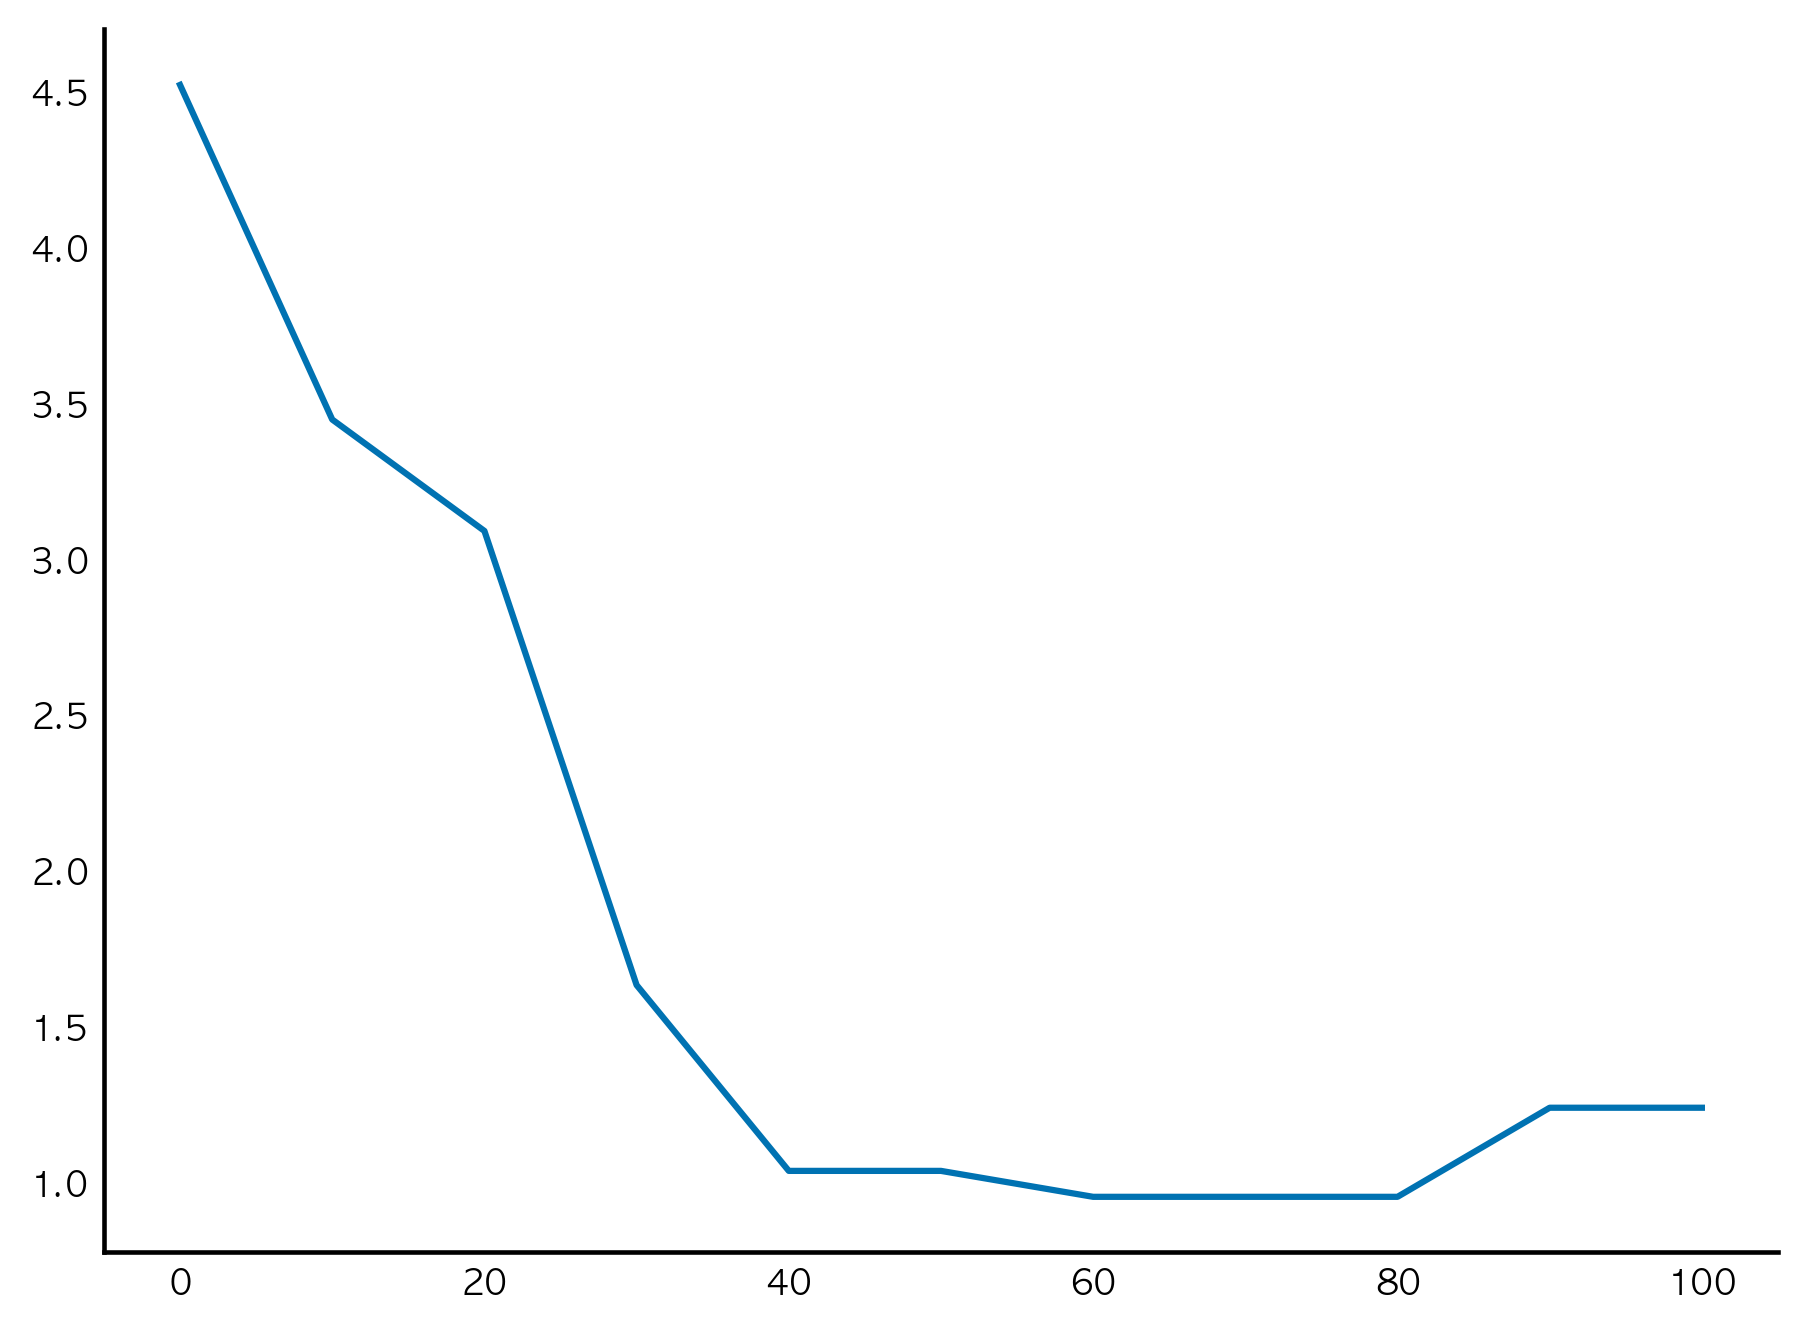

In [83]:
# 임계값 실험
def vi_at_threshold(seg, tiger, human_seg, threshold):
    auto_seg = rag_segmentation(seg, tiger, threshold)
    return variation_of_information(auto_seg, human_seg)

thresholds = range(0, 110, 10)
vi_per_threshold = [vi_at_threshold(seg, tiger, human_seg, threshold)
                    for threshold in thresholds]

plt.plot(thresholds, vi_per_threshold);

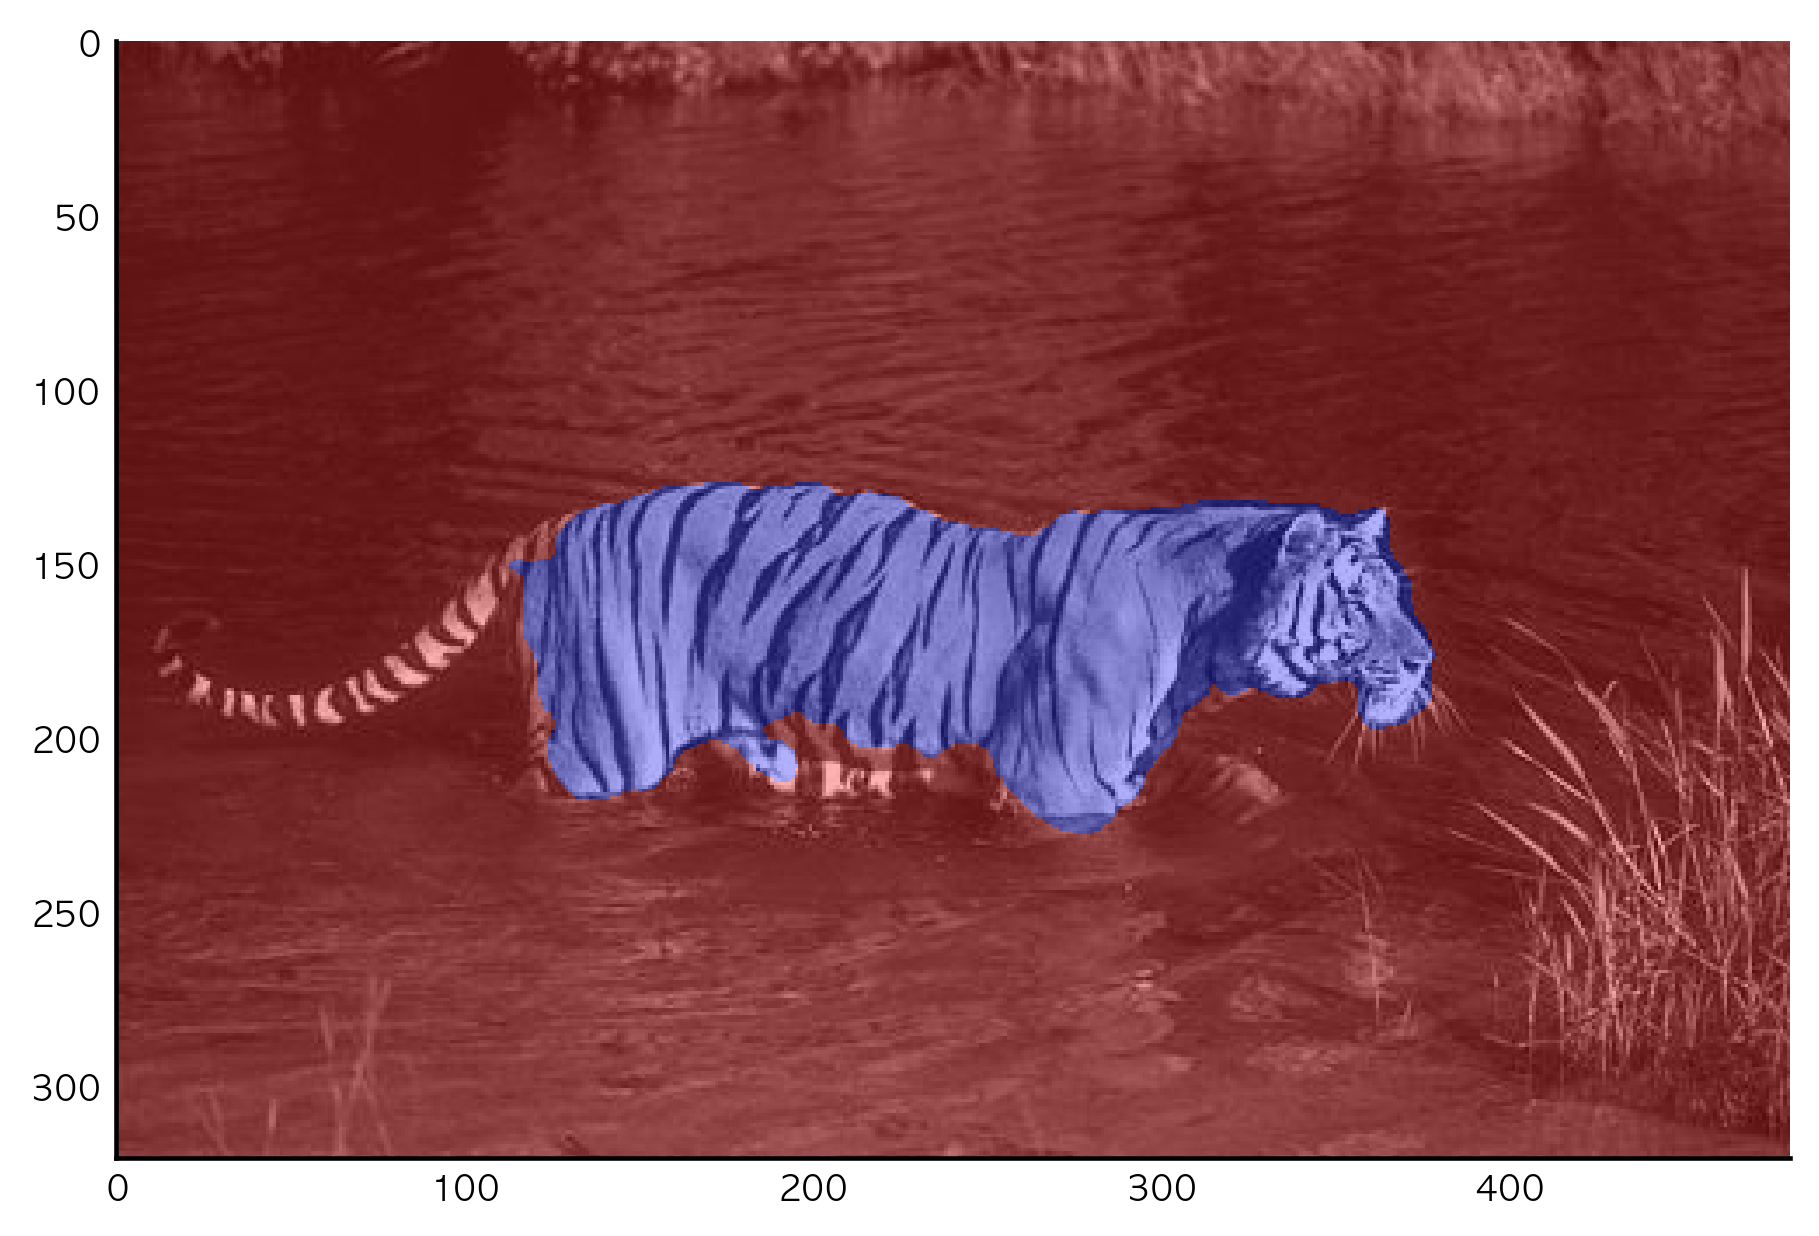

In [84]:
auto_seg = rag_segmentation(seg, tiger, threshold=80)
plt.imshow(color.label2rgb(auto_seg, tiger));